In [2]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 17.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which i

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from datasets import load_dataset
from tokenizers import Tokenizer
from tokenizers.models import WordLevel
from tokenizers.trainers import WordLevelTrainer
from tokenizers.pre_tokenizers import Whitespace
from collections import Counter
import random
from tqdm import tqdm

In [4]:
# load dataset
# different Subset ->
dataset = load_dataset("wikitext", "wikitext-103-raw-v1")

dataset

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/733k [00:00<?, ?B/s]

train-00000-of-00002.parquet:   0%|          | 0.00/157M [00:00<?, ?B/s]

train-00001-of-00002.parquet:   0%|          | 0.00/157M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/657k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/4358 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/1801350 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3760 [00:00<?, ? examples/s]

DatasetDict({
    test: Dataset({
        features: ['text'],
        num_rows: 4358
    })
    train: Dataset({
        features: ['text'],
        num_rows: 1801350
    })
    validation: Dataset({
        features: ['text'],
        num_rows: 3760
    })
})

In [5]:
train_texts = dataset["train"]["text"]
valid_texts = dataset["validation"]["text"]

train_texts = [text for text in train_texts if text.strip()]
valid_texts = [text for text in valid_texts if text.strip()]

print(f"Training samples: {len(train_texts)}")
print(f"Validation samples: {len(valid_texts)}")
print(f"\nFirst training example: {train_texts[0][:]}...")
print(f"\nFirst training example: {train_texts[1][:]}...")


Training samples: 1165029
Validation samples: 2461

First training example:  = Valkyria Chronicles III = 
...

First training example:  Senjō no Valkyria 3 : Unrecorded Chronicles ( Japanese : 戦場のヴァルキュリア3 , lit . Valkyria of the Battlefield 3 ) , commonly referred to as Valkyria Chronicles III outside Japan , is a tactical role @-@ playing video game developed by Sega and Media.Vision for the PlayStation Portable . Released in January 2011 in Japan , it is the third game in the Valkyria series . Employing the same fusion of tactical and real @-@ time gameplay as its predecessors , the story runs parallel to the first game and follows the " Nameless " , a penal military unit serving the nation of Gallia during the Second Europan War who perform secret black operations and are pitted against the Imperial unit " Calamaty Raven " . 
...


In [6]:
# Initialize tokenizer
tokenizer = Tokenizer(WordLevel(unk_token="[UNK]"))
tokenizer.pre_tokenizer = Whitespace()

#train Tokenizer

trainer = WordLevelTrainer(
                          special_tokens=["[UNK]"],
                           min_frequency =2)

# train on out corpus
tokenizer.train_from_iterator(train_texts, trainer)

# save tokenizer
tokenizer.save("tokenizer.json")

print(f"Vocabulary size: {tokenizer.get_vocab_size()}")

# The tokenizer learns from our training texts
# It builds a vocabulary of all words that appear ≥2 times
# It assigns each word a unique number (ID)
# This creates a mapping: word ↔ number


Vocabulary size: 30000


In [7]:
# Now let's create a dataset class for the Skip-gram model
#  (predicts context words from target word):


class SkipGramDataset(Dataset):
    def __init__(self, texts, tokenizer, window_size=2):
        self.window_size = window_size
        self.tokenizer = tokenizer
        self.data = []

        # Create skip-gram pairs
        for text in tqdm(texts, desc="Creating dataset"):
            # Tokenize text
            encoding = tokenizer.encode(text)
            tokens = encoding.ids

            # Create (target, context) pairs
            for i, target in enumerate(tokens):
                # Get context window
                start = max(0, i - window_size)
                end = min(len(tokens), i + window_size + 1)

                # Add each context word as a separate training example
                for j in range(start, end):
                    if i != j:  # Skip the target word itself
                        self.data.append((target, tokens[j]))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        target, context = self.data[idx]
        return torch.tensor(target), torch.tensor(context)

# Create datasets
train_dataset = SkipGramDataset(train_texts[:1000], tokenizer)  # Using subset for speed
valid_dataset = SkipGramDataset(valid_texts[:100], tokenizer)

print(f"Training pairs: {len(train_dataset)}")
print(f"Validation pairs: {len(valid_dataset)}")


Creating dataset: 100%|██████████| 100/100 [00:00<00:00, 3858.43it/s]

Training pairs: 349964
Validation pairs: 36416


In [8]:
class SkipGram(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(SkipGram, self).__init__()

        # Target word embeddings
        self.target_embeddings = nn.Embedding(vocab_size, embedding_dim)

        # Context word embeddings
        self.context_embeddings = nn.Embedding(vocab_size, embedding_dim)

    def forward(self, target_ids, context_ids):
        # Get embeddings
        target_embeds = self.target_embeddings(target_ids)
        context_embeds = self.context_embeddings(context_ids)

        # Compute dot product
        scores = torch.sum(target_embeds * context_embeds, dim=1)

        return scores

# Initialize model
vocab_size = tokenizer.get_vocab_size()
embedding_dim = 100
model = SkipGram(vocab_size, embedding_dim)

print(f"Model initialized with vocab_size={vocab_size}, embedding_dim={embedding_dim}")


Model initialized with vocab_size=30000, embedding_dim=100


In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

class NegativeSamplingLoss(nn.Module):
    def __init__(self):
        super(NegativeSamplingLoss, self).__init__()

    def forward(self, positive_scores, negative_scores):
        # Loss for positive samples (should be high)
        positive_loss = -torch.log(torch.sigmoid(positive_scores)).mean()

        # Loss for negative samples (should be low)
        negative_loss = -torch.log(torch.sigmoid(-negative_scores)).mean()

        return positive_loss + negative_loss

def get_negative_samples(batch_size, vocab_size, num_negatives=5, device='cuda'): # Added device argument
    """Generate negative samples for training"""
    return torch.randint(0, vocab_size, (batch_size * num_negatives,), device=device) # Create tensor on specified device

def train_epoch(model, dataloader, optimizer, criterion, vocab_size, num_negatives=5, device='cuda'):
    model.train()
    total_loss = 0

    for target_ids, context_ids in tqdm(dataloader, desc="Training"):
        # Move data to device
        target_ids = target_ids.to(device)
        context_ids = context_ids.to(device)

        optimizer.zero_grad()

        # Positive samples
        positive_scores = model(target_ids, context_ids)

        # Negative samples
        batch_size = target_ids.size(0)
        negative_context_ids = get_negative_samples(batch_size, vocab_size, num_negatives)
        negative_context_ids = negative_context_ids.to(device)  # Move to device

        # Expand target_ids for negative samples
        target_ids_expanded = target_ids.repeat_interleave(num_negatives)
        negative_scores = model(target_ids_expanded, negative_context_ids)

        # Calculate loss
        loss = criterion(positive_scores, negative_scores)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)



Training: 100%|██████████| 2735/2735 [00:15<00:00, 178.55it/s]


Epoch 1/1, Loss: 6.2663


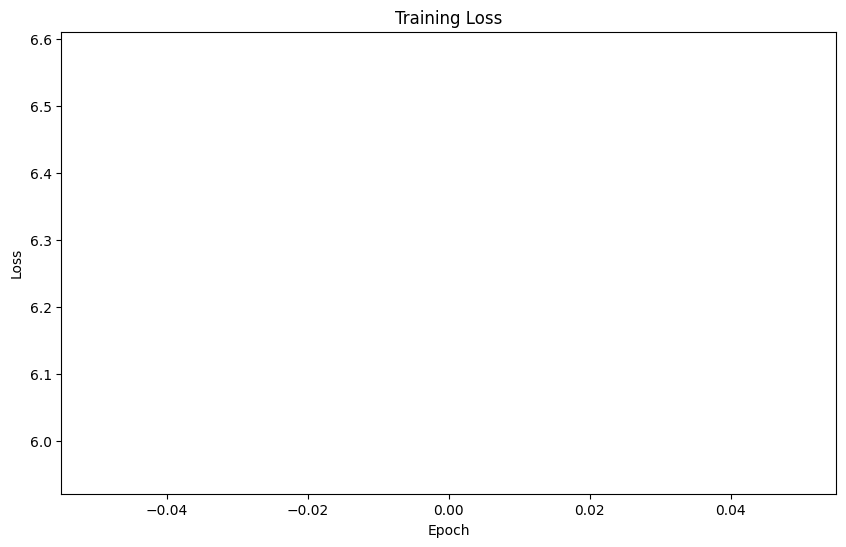

In [10]:
# Training settings
batch_size = 128
learning_rate = 0.001
num_epochs = 1
num_negatives = 5

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size)

# Initialize optimizer and loss
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = NegativeSamplingLoss()

# Training loop
train_losses = []
for epoch in range(num_epochs):
    train_loss = train_epoch(model, train_loader, optimizer, criterion, vocab_size, num_negatives, device='cuda')
    train_losses.append(train_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {train_loss:.4f}")

# Plot training loss
plt.figure(figsize=(10, 6))
plt.plot(train_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

In [11]:
def get_word_embedding(word, tokenizer, model):
    """Get embedding for a word"""
    model.cpu()
    token_id = tokenizer.encode(word).ids[0]
    embedding = model.target_embeddings.weight[token_id].detach().numpy()
    return embedding

def find_similar_words(word, tokenizer, model, top_k=5):
    """Find most similar words based on cosine similarity"""
    # Get embedding for target word
    target_embedding = get_word_embedding(word, tokenizer, model)

    # Get all embeddings
    all_embeddings = model.target_embeddings.weight.detach().numpy()

    # Calculate cosine similarities
    similarities = np.dot(all_embeddings, target_embedding)
    similarities /= np.linalg.norm(all_embeddings, axis=1) * np.linalg.norm(target_embedding)

    # Get top k similar words
    top_indices = np.argsort(similarities)[-top_k-1:-1][::-1]

    # Get words from indices
    vocab = tokenizer.get_vocab()
    id_to_word = {v: k for k, v in vocab.items()}

    similar_words = []
    for idx in top_indices:
        if idx in id_to_word:
            similar_words.append((id_to_word[idx], similarities[idx]))

    return similar_words

# Test similarity search
test_words = ["king", "computer", "apple", "good", "bad"]
for word in test_words:
    if word in tokenizer.get_vocab():
        print(f"\nWords similar to '{word}':")
        similar = find_similar_words(word, tokenizer, model)
        for sim_word, score in similar:
            print(f"  {sim_word}: {score:.3f}")


Words similar to 'king':
  Hove: 0.437
  termination: 0.392
  AL: 0.390
  Mays: 0.382
  Inter: 0.381

Words similar to 'computer':
  Wesley: 0.399
  bulb: 0.365
  Royalists: 0.364
  Kaling: 0.362
  Albania: 0.340

Words similar to 'apple':
  famine: 0.362
  departure: 0.356
  mule: 0.355
  dwellings: 0.348
  Directed: 0.340

Words similar to 'good':
  McKinley: 0.412
  fault: 0.401
  305: 0.374
  citation: 0.373
  Diamond: 0.355

Words similar to 'bad':
  Carroll: 0.386
  flattened: 0.382
  science: 0.378
  breaks: 0.362
  rejoining: 0.358


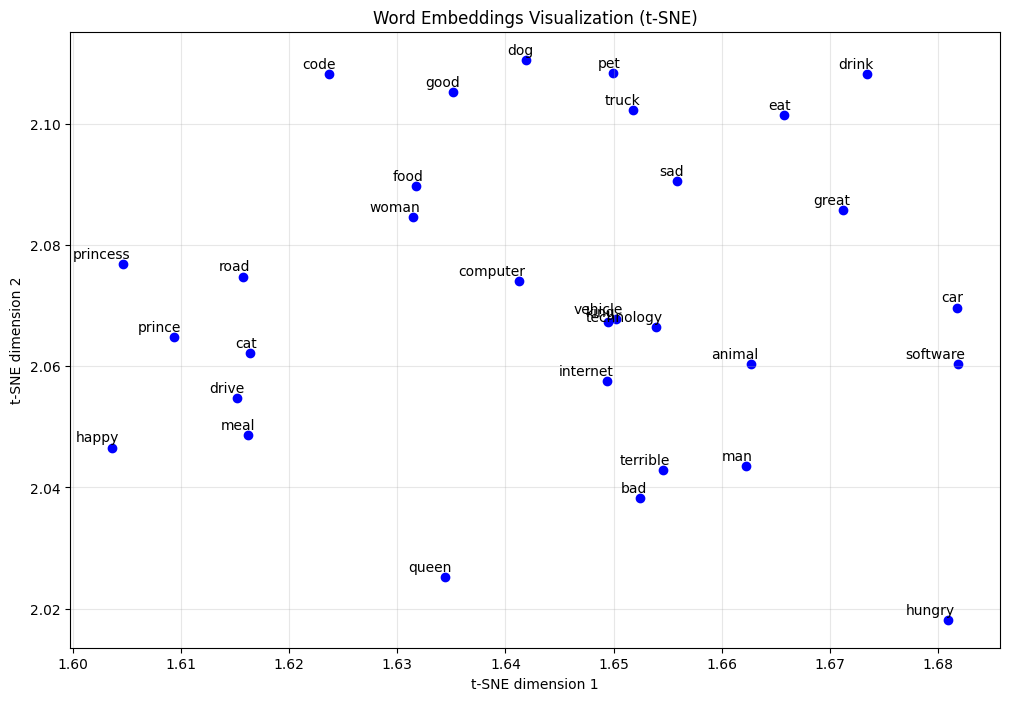

In [12]:
def visualize_embeddings(words, tokenizer, model):
    """Visualize word embeddings using t-SNE"""
    # Get embeddings for selected words
    embeddings = []
    valid_words = []

    for word in words:
        if word in tokenizer.get_vocab():
            embedding = get_word_embedding(word, tokenizer, model)
            embeddings.append(embedding)
            valid_words.append(word)

    if not embeddings:
        print("No valid words found!")
        return

    # Apply t-SNE
    embeddings_matrix = np.array(embeddings)
    tsne = TSNE(n_components=2, random_state=42)
    embeddings_2d = tsne.fit_transform(embeddings_matrix)

    # Plot
    plt.figure(figsize=(12, 8))
    for i, word in enumerate(valid_words):
        x, y = embeddings_2d[i]
        plt.scatter(x, y, marker='o', color='blue')
        plt.annotate(word, xy=(x, y), xytext=(5, 2),
                    textcoords='offset points', ha='right', va='bottom')

    plt.title('Word Embeddings Visualization (t-SNE)')
    plt.xlabel('t-SNE dimension 1')
    plt.ylabel('t-SNE dimension 2')
    plt.grid(True, alpha=0.3)
    plt.show()

# Select words to visualize
words_to_visualize = [
    "king", "queen", "man", "woman", "prince", "princess",
    "good", "bad", "happy", "sad", "great", "terrible",
    "dog", "cat", "animal", "pet", "puppy", "kitten",
    "computer", "software", "technology", "internet", "code",
    "car", "truck", "vehicle", "drive", "road",
    "food", "eat", "drink", "hungry", "meal"
]

visualize_embeddings(words_to_visualize, tokenizer, model)


In [13]:
# Save embeddings
model.cpu()
torch.save(model.target_embeddings.state_dict(), 'embeddings.pt')

# To load embeddings later:
# loaded_embeddings = nn.Embedding(vocab_size, embedding_dim)
# loaded_embeddings.load_state_dict(torch.load('embeddings.pt'))

# Save full model
torch.save(model.state_dict(), 'skipgram_model.pt')

# Export embeddings to numpy format
embeddings_matrix = model.target_embeddings.weight.detach().numpy()
np.save('embeddings_matrix.npy', embeddings_matrix)

# Save vocabulary mapping
vocab = tokenizer.get_vocab()
import json
with open('vocab.json', 'w') as f:
    json.dump(vocab, f)

print("Model and embeddings saved successfully!")



Model and embeddings saved successfully!


In [14]:
# Simple Context Generator using Trained Embeddings

import torch
import torch.nn as nn
import numpy as np
import json

# Recreate the SkipGram model architecture
class SkipGram(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(SkipGram, self).__init__()
        self.target_embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.context_embeddings = nn.Embedding(vocab_size, embedding_dim)

    def forward(self, target_ids, context_ids):
        target_embeds = self.target_embeddings(target_ids)
        context_embeds = self.context_embeddings(context_ids)
        scores = torch.sum(target_embeds * context_embeds, dim=1)
        return scores

# Load saved vocabulary
with open('vocab.json', 'r') as f:
    vocab = json.load(f)

# Create reverse mapping (ID to word)
id_to_word = {v: k for k, v in vocab.items()}
vocab_size = len(vocab)
embedding_dim = 100  # Must match your trained model

# Initialize model and load weights
model = SkipGram(vocab_size, embedding_dim)
model.load_state_dict(torch.load('skipgram_model.pt'))
model.eval()

def get_context_words(word, top_k=10):
    """
    Get most likely context words for a given input word

    Args:
        word: The input word
        top_k: Number of context words to return

    Returns:
        List of (word, probability) tuples
    """

    # Check if word exists in vocabulary
    if word not in vocab:
        print(f"Word '{word}' not in vocabulary!")
        return []

    # Get word ID
    word_id = vocab[word]

    # Create input tensor
    target_tensor = torch.tensor([word_id])

    # Get all possible context IDs
    all_context_ids = torch.arange(vocab_size)

    with torch.no_grad():
        # Get target embedding
        target_embed = model.target_embeddings(target_tensor)

        # Get all context embeddings
        context_embeds = model.context_embeddings(all_context_ids)

        # Calculate scores
        scores = torch.matmul(target_embed, context_embeds.t()).squeeze()

        # Apply sigmoid to get probabilities
        probs = torch.sigmoid(scores)

        # Get top k indices
        top_k_values, top_k_indices = torch.topk(probs, top_k)

        # Convert to words
        results = []
        for idx, prob in zip(top_k_indices, top_k_values):
            word = id_to_word.get(idx.item(), "[UNK]")
            results.append((word, prob.item()))

    return results

# Example usage
test_words = ["king", "computer", "good", "apples",'apple', "city"]

for word in test_words:
    print(f"\nContext words for '{word}':")
    context_words = get_context_words(word, top_k=10)

    if context_words:
        for i, (context_word, prob) in enumerate(context_words, 1):
            print(f"{i}. {context_word}: {prob:.4f}")
    else:
        print(f"Word '{word}' not found in vocabulary")
    print("-" * 40)



Context words for 'king':
1. off: 1.0000
2. there: 1.0000
3. own: 1.0000
4. game: 1.0000
5. any: 1.0000
6. set: 1.0000
7. similar: 1.0000
8. times: 1.0000
9. water: 1.0000
10. 2007: 1.0000
----------------------------------------

Context words for 'computer':
1. —: 1.0000
2. began: 1.0000
3. members: 1.0000
4. with: 1.0000
5. video: 1.0000
6. former: 1.0000
7. miles: 1.0000
8. 26: 1.0000
9. given: 1.0000
10. 6: 1.0000
----------------------------------------

Context words for 'good':
1. which: 1.0000
2. @,@: 1.0000
3. I: 1.0000
4. him: 1.0000
5. [UNK]: 1.0000
6. later: 1.0000
7. most: 1.0000
8. made: 1.0000
9. this: 1.0000
10. (: 1.0000
----------------------------------------

Context words for 'apples':
1. 3: 1.0000
2. film: 1.0000
3. home: 1.0000
4. but: 1.0000
5. during: 1.0000
6. ship: 1.0000
7. 2007: 1.0000
8. One: 1.0000
9. line: 1.0000
10. final: 1.0000
----------------------------------------

Context words for 'apple':
1. at: 1.0000
2. during: 1.0000
3. being: 1.0000
4. fo